## Astro 330 "Computational Astrophysics"

### Homework 5. Computational statistics (50 points + 15 extra credit)

### Distributed 20 November; due Thursday, November 30, 9pm. 

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np

# from code.setup import data_home_dir
from matplotlib import pyplot as plt
%matplotlib inline
# from plot_utils import plot_pretty

# plot_pretty()


### 1. Fitting a linear model to data (20 points)

#### Exercise desription

Assuming that uncertainties of $V_{\rm rot}$ and $M_{\rm b}$ are uncorrelated, use the likelihoods, as well as appropriate priors (choice is up to you), to derive constraints on the intercept, slope, and *intrinsic* scatter of the $M_{\rm b}-V_{\rm rot}$ relation for the following cases:

1. Using only one randonly chosen data point.
2. Using 2 randomly chosen data points.
3. Using all data points using different choices of models and likelihoods.

#### Solution 

1. Using the model that is symmetric relative to switch between these quantities as $x$ and $y$, described in the lecture notes (S 3.4.2) and in notebook ex15, derive and plot the marginalized posterior distributions for slope and intercept, $m$ and $c$ for the likelihood given by eq. 3.55 in the notes when using only 1 random data points, 2 random data points, and all data points. For the latter plot also posterior for the scatter in the perpendicular to the line direction, $s_\perp$. Compute 68\% and 95% credible regions for $m$, $c$, and $c_\perp$. (5 points)

Read the data and prepare it for analysis.

In [1]:
import pyfits

bf1 = pyfits.open('bradford16_fig1.fits')[1].data
print bf1.columns


ColDefs(
    name = 'NSAID'; format = 'J'
    name = 'MI'; format = 'D'
    name = 'MI_ERR'; format = 'D'
    name = 'MSTAR'; format = 'D'
    name = 'MSTAR_ERR'; format = 'D'
    name = 'MGAS'; format = 'D'
    name = 'MGAS_ERR'; format = 'D'
    name = 'MBARYON'; format = 'D'
    name = 'MBARYON_ERR'; format = 'D'
    name = 'VW20I'; format = 'D'
    name = 'VW20I_ERR'; format = 'D'
)


Routine implementing GW10 MCMC sampling method from hw04_solutions is now included in <tt>code/mcmc.py</tt> and the relevant routines are simply imported here. 

I will first do the fit assuming prior uniform in angle and uniform in normalization. The latter is defined as distance from the the line to the origin, and thus $p(m,c)\propto 1/(1+m^2)^{3/2}$, as described in S 3.4.2 of the notes. I also assume a flat prior on the variance $s_\perp^2$. 

In [2]:
from mcmc import mcmc_sample, mcmc_sample_init

In [3]:
# likelihood for fitting the line to a set of points with the Gaussian scatter 
# and error bars in both variables (correlation between error bars 
# can be specified in covariance matrix elements c00, c01, c11
# derived from the original version by Surhud More (2011)

cmin = -100; cmax = 100 # flat prior range on normalization
smin = 0.; smax = 2. # flat prior range on scatter
# normalization factor; 0.5 is from the normalization by the integral int^{infty}_{-infty} dm/(1+m^2)^{3/2}

normfact = 0.5/(smax - smin)/(cmax - cmin)

def prior(xd):
    """
    defines parameter priors
    
    Parameters
    ----------
    xd : numpy 1d array
        xd[0] = slope; xd[1] = normalization; xd[2] = scatter
        
    Returns
    -------
    numpy float
        ln(prior)
        
    """
    if cmin <= xd[1] and xd[1] < cmax and smin <= xd[2] and xd[2] < smax:
        return np.log(normfact/(1. + xd[0]**2)**1.5)
    else:
        return -100.

def line_fit_vert_like (x, params=None): 
    """
    likelihood for a linear model for data with error bars in both directions 
    and intrinsic scatter in y direction
    the merit function is also in y-direction (see d'Agostino 2005)
    Thus, this likelihood will resolve in different results when fit as y(x) or x(y)
    
    Parameters
    -----------
    x : vector of parameters: 
    x[0] : slope m; x[1] = intercept c; x[2]=intrinsic scatter
    params : [x, y, c00, c01, c11]            
    
    Returns
    -------
    numpy array
        likelihood values for each walker
    """
    p = params; nw = np.shape(x)[0]; res = np.zeros(nw)
    for i in range(nw):
        dummy = x[i,2] + p[4] + x[i,0]**2*p[2]
        res[i] = -0.5*(np.sum(np.log(dummy))+np.sum((p[1]-x[i,0]*p[0]-x[i,1])**2/dummy)) \
                + prior(x[i,:])
    return res

def line_fit_like(x, params=None):
    """
    likelihood describing model with Gaussian distribution perpendicular to the mean
    linear relation and data points with correlated Gaussian uncertainties in both x and y
    This likelihood should return identical results for fits of y(x) and 
    
    Parameters
    ----------
    x: numpy vector
     x[0] = slope; x[1] = normalization; x[2] = variance in the perp direction
    params: numpy vector
     params = [x, y, c00, c01, c11] 
     
    Returns
    -------
    numpy array
        likelihood values for each walker
        
    """
    p = params; nw = np.shape(x)[0]; res = np.zeros(nw)
    
    for i in range(nw):
        m2 = x[i,0] * x[i,0]
        r = 1. + m2
        sigtot2  = x[i,2]*r + p[2]*m2 - 2.*p[3]*x[i,0] + p[4]
        d2 = (p[1] - x[i,0]*p[0] - x[i,1])**2 # y-mx-s
        siginv1 = r / (2.0*np.pi*sigtot2)
        res[i] = np.sum(0.5*(np.log(siginv1) - d2/sigtot2)) + \
                        prior(x[i,:])

    return res

In [4]:
def mcmc_fit(x, y, ex, ey, pini=None, ipar_active=None, nwalkers=None, modelpdf=None):
    # covariance matrix of errors
    c00 = ex*ex; c01 = 0.; c11 = ey*ey
    p = pini; params = [x, y, c00, c01, c11]
    nparams = 3
    x0 = np.array(p[0:nparams]); step = 0.1*np.array(np.abs(p[0:nparams]));
    iz = (step == 0); step[iz] = 0.01 
    # define which parameters are active (=1), and which should stay fixed (=0)
    
    # initialize MCMC walkers
    xwalk = mcmc_sample_init(nparams=nparams, nwalkers=nwalkers, x0=x0, step=step, ipar_active=ipar_active)
    
    # run the sampler
    nRval = 500 # record Gelman-Rubin R indicator each nRval'th step
    # now get the chain and how many values to thin based on the final auto-correlation time
    chain, Rval, nthin = mcmc_sample(xwalk, nparams=nparams, nwalkers=nwalkers, nRval=nRval, 
                                    modelpdf=modelpdf, Rlim = 1.01, params=params, ipar_active=ipar_active)
    return chain, Rval, nthin


In [5]:
def pstats(x):
    """
    print chain mean, median, and confidence intervals
    """
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    xcfl11 = np.percentile(x,16); xcfl12 = np.percentile(x,84)
    xcfl21 = np.percentile(x,2.5); xcfl22 = np.percentile(x,97.5)
    dashedline = '----------------------------------------------'
    print('mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd))
    print('68perc interval = %.3f, %.3f'%(xcfl11,xcfl12))
    print('95perc interval = %.3f, %.3f'%(xcfl21,xcfl22))
    print('%s'%dashedline)


In [8]:
mbbar = bf1['MBARYON']; embar = bf1['MBARYON_ERR']
w20b = bf1['VW20I']; ew20b = bf1['VW20I_ERR']

iews = w20b < ew20b; 
iewl = w20b > ew20b
iwz = ew20b == 0; 
e_x = np.zeros_like(ew20b)
e_x[iews] = ew20b[iews]/(w20b[iews]*np.log(10.))
e_x[iewl] = 0.5*np.log10((ew20b[iewl]+w20b[iewl])/(w20b[iewl]-ew20b[iewl]))
e_x[iwz] = 100,


We will be running many different fits and plotting their results, so let's prepare corresponding routines for doing so, to avoid duplication of code. 

In [9]:
def run_fit(x, ex, y, ey, nwalkers=100, m0=None, c0=None, s0= None, 
            ipar_active=None, modelpdf=line_fit_like):
    """
    run MCMC sampling of the posterior and extract fit parameters from the chain
    """

    chain, Rval, nthin = mcmc_fit(x, y, ex, ey, pini=[m0, c0, s0], 
                                  ipar_active=ipar_active, nwalkers=nwalkers, 
                                  modelpdf=modelpdf)

    nburn = int(20*nwalkers*nthin)

    m = zip(*chain)[0]; c = zip(*chain)[1]; s = np.sqrt(zip(*chain)[2])
    mc = m[nburn:]; cc = c[nburn:]; sc = s[nburn:]
    return mc, cc, sc

from plot_utils import plot_2d_dist

clevs = (0.683, 0.955, 0.997) # standard contour levels

def plot_fit(m, c, s, mlim=None, clim=None, slim=None, p_stats = False):
    """
    plot posterior and some of its statistics
    
    """
    fig, ax = plt.subplots(1,2, figsize=(4.,2.))
    
    plt.tight_layout(); plt.rc('font',size=9)
    fig.subplots_adjust(hspace=1.7)

    plot_2d_dist(m, c, xlim=mlim, ylim=clim, nxbins=41, nybins=41, clevs=clevs[::-1], 
                 smooth=True, xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{normalization}$', fig_setup=ax[0])

    ax[1].yaxis.set_label_position('right')
    plot_2d_dist(m, s, xlim=mlim, ylim=slim, nxbins=41, nybins=41, clevs=clevs[::-1], smooth=True,
                 xlabel=r'$\mathrm{slope}$', ylabel=r'$\mathrm{scatter}$', fig_setup=ax[1])
    plt.show()
    if p_stats:
        print("%s"%"====== Bradford et al. BTFR sample perpendicular likelihood ======")
        print("%s"%"best fit slope:")
        pstats(m)
        print("%s"%"best fit normalization")
        pstats(c)
        print("%s"%"best fit scatter:")
        pstats(s)
        
    return

Now, let's see what kind of posterior we get for one data point.

In [10]:
ids,M,temp=np.loadtxt('temperature.txt',unpack=True)
T=temp/1.16e7

In [11]:
nr = [10] 
x = np.log10(w20b[nr]); ex = e_x[nr]
y = mbbar[nr]; ey = embar[nr] 

m, c, s = run_fit(x, ex, y, ey, m0=4., c0=0., s0=0.05, ipar_active=np.array([1, 1, 1]))

starting sampling with 3 active parameters of the total 3 parameters


/Users/hqchen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in log
mcmc.py:57: RuntimeWarning: invalid value encountered in greater
  iacc = np.where(gr>0.)
mcmc.py:62: RuntimeWarning: invalid value encountered in greater
  iprob = np.where(aprob>np.log(u))


nchain = 500; tcorr = 2.54e+01
('R_GR = ', array([ 1.14136673,  1.12645386,  1.09914012]))
nchain = 1000; tcorr = 2.91e+01
('R_GR = ', array([ 1.07305171,  1.07860756,  1.04861156]))
nchain = 1500; tcorr = 2.60e+01
('R_GR = ', array([ 1.04397942,  1.04212593,  1.0310436 ]))
nchain = 2000; tcorr = 2.27e+01
('R_GR = ', array([ 1.03530258,  1.03616981,  1.02361841]))
nchain = 2500; tcorr = 2.01e+01
('R_GR = ', array([ 1.02461119,  1.02551875,  1.01745204]))
nchain = 3000; tcorr = 2.11e+01
('R_GR = ', array([ 1.01913572,  1.01999826,  1.01517504]))
nchain = 3500; tcorr = 8.79e+01
('R_GR = ', array([ 1.01767748,  1.01781393,  1.0136139 ]))
nchain = 4000; tcorr = 6.29e+01
('R_GR = ', array([ 1.01507405,  1.01495258,  1.01029279]))
nchain = 4500; tcorr = 6.56e+01
('R_GR = ', array([ 1.01244853,  1.01338709,  1.00954239]))
nchain = 5000; tcorr = 5.21e+01
('R_GR = ', array([ 1.01176481,  1.0118246 ,  1.00834064]))
nchain = 5500; tcorr = 6.04e+01
('R_GR = ', array([ 1.01138645,  1.01150645,  1.0

/Users/hqchen/anaconda/lib/python2.7/site-packages/scipy/signal/signaltools.py:615: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/Users/hqchen/anaconda/lib/python2.7/site-packages/scipy/signal/signaltools.py:615: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/Users/hqchen/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


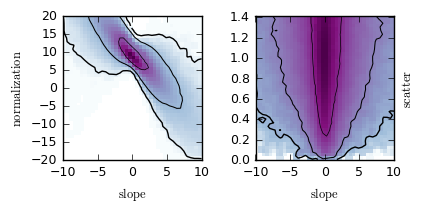

In [12]:
plot_fit(m, c, s, mlim=[-10., 10.], clim=[-20., 20.], 
         slim=[np.min(s), np.max(s)], p_stats=False)

Posterior distribution for $m$ and $c$ when using a single data point has diagonal degeneracy in the $m-c$ plane because
a single $(x,y)$ measurement with its uncertainty constrains a linear combination of $c$ and $m$: $c= y - mx$. The uncertainty of the measurement results in a diffuse diagonal "band", which would be a line if uncertainties of $y$ and $x$ were negligible. 

No other information on the posterior should be available and everything else we see except for the diagonal $m-c$ degeneracy reflects the adopted priors. 

Along the degeneracy direction, the distribution of probability reflects prior on $m$ and $c$, in particular the prior on $m$: 

$$p(m)\propto \frac{dm}{(1+m^2)^{3/2}},$$

which is symmetric around $m=0$. The scatter posterior also looks like it has some information - the probability is highest near unity, and values of the scatter near zero are less likely. Clearly, we could not have obtained any information about scatter from a single data point. Thus, what we are seeing must reflect the prior. This may be surprising because the prior on scatter was assumed to be uniform in the range of $0\leq s_\perp\leq 2$. The posterior for scatter is not uniform, however, due to the way the likelihood depends on the scatter. 

If we instead adopt the Jeffreys prior on the scatter:

$$p(s_\perp)\propto \frac{1}{s_\perp},$$

we will get the following. 

In [13]:
cmin = -100; cmax = 100 # flat prior range on normalization
smin = 1.e-16; smax = 1.e16 # flat prior range on scatter
# normalization factor; 0.5 is from the normalization by the integral int^{infty}_{-infty} dm/(1+m^2)^{3/2}

normfact = 0.5 / np.log(smax/smin) / (cmax - cmin)

def prior(xd):
    """
    defines parameter priors
    
    Parameters
    ----------
    xd : numpy 1d array
        xd[0] = slope; xd[1] = normalization; xd[2] = scatter
        
    Returns
    -------
    numpy float
        ln(prior)
        
    """
    if cmin <= xd[1] and xd[1] < cmax and smin <= xd[2] and xd[2] < smax:
        return np.log(normfact/(1. + xd[0]**2)**1.5/np.sqrt(xd[2]))
    else:
        return -100.


In [17]:
ids,x,y=np.loadtxt('Tbulknocore_M.txt',unpack=True)
T=np.log10(x)
M=np.log10(y)
eT=np.zeros_like(T)
eM=np.zeros_like(M)

m, c, s = run_fit(M, eM, T, eT, m0=0.6, c0=-8.7, s0=0.05, 
                  ipar_active=np.array([1, 1, 1]))

params [array([ 14.60834415,  14.49182376,  15.09124477,  14.50403567,
        14.47420169,  14.55882852,  14.60827993,  14.70530766,
        14.50070291,  14.51066563,  14.86953093,  14.83397537,
        14.39511662,  14.59272067,  14.60646736,  14.38394097,
        14.62922606,  14.67380396,  14.49454417,  14.73493578,
        14.5624713 ,  14.67115432,  14.67757958,  14.6839741 ,
        14.80430303,  14.58403707,  14.48492591,  14.51110762,
        14.71483251,  14.55556599,  14.38533811,  14.52087638,
        14.80096439,  14.50858358,  14.42735626,  14.49009901,
        14.72421851,  14.74955081,  14.59705863,  14.52513555,
        14.49583562,  14.49972831,  14.82759541,  14.51263104,
        14.55057076,  15.02044416,  14.56407398,  14.72720768,
        14.64019314,  14.54501006,  14.26030995,  14.59582678,
        14.43627399,  14.57385752,  14.56364718,  14.54907687,
        14.48652965,  14.47469693,  14.50414451,  14.54899099,
        14.24583334,  14.71687107,  14.49197767

/Users/hqchen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in log


nchain = 500; tcorr = 1.40e+01
('R_GR = ', array([ 1.07004971,  1.07224   ,  1.00532996]))
nchain = 1000; tcorr = 1.41e+01
('R_GR = ', array([ 1.03111803,  1.03217336,  1.0025249 ]))
nchain = 1500; tcorr = 1.38e+01
('R_GR = ', array([ 1.02178721,  1.02241265,  1.00157758]))
nchain = 2000; tcorr = 5.67e+01
('R_GR = ', array([ 1.01637148,  1.01674549,  1.00116465]))
nchain = 2500; tcorr = 5.53e+01
('R_GR = ', array([ 1.01294852,  1.01322454,  1.00095461]))
nchain = 3000; tcorr = 5.53e+01
('R_GR = ', array([ 1.01200393,  1.01223147,  1.00084478]))
nchain = 3500; tcorr = 5.43e+01
('R_GR = ', array([ 1.00990566,  1.01004917,  1.00074209]))
nchain = 4000; tcorr = 5.35e+01
('R_GR = ', array([ 1.00871936,  1.00877655,  1.00068367]))
MCMC sampler generated 400000 samples using 100 walkers
with step acceptance ratio of 0.560


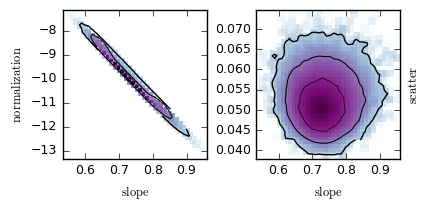

====== Bradford et al. BTFR sample perpendicular likelihood ======
best fit slope:
mean, median = 0.728, 0.727, st.dev=0.0435
68perc interval = 0.686, 0.770
95perc interval = 0.644, 0.818
----------------------------------------------
best fit normalization
mean, median = -9.955, -9.941, st.dev=0.6331
68perc interval = -10.564, -9.345
95perc interval = -11.259, -8.727
----------------------------------------------
best fit scatter:
mean, median = 0.052, 0.051, st.dev=0.0041
68perc interval = 0.048, 0.056
95perc interval = 0.044, 0.061
----------------------------------------------


In [18]:
plot_fit(m, c, s, mlim=[np.min(m), np.max(m)], clim=[np.min(c), np.max(c)], 
         slim=[np.min(s), np.max(s)], p_stats=True)

Now we can see that posteriors for the parameters are pretty well constrained. There is still degeneracy between normalization and slope, but both quantities are now constrained to vary in well defined ranges. The degeneracy itsels is due to the particular definition of normalization that we are plotting here. This is an intercept of $y$ at $x=0$. In this case this is $\log_{10} V_{\rm max}=0$. However, all of our data points have $\log_{10}V_{\rm max}\gg 0$. Thus, variation of slope due to its uncertainties result in large variation of the intercept due to a long lever arm between where the constraints actually are and $x=0$ of the intercept. 

This can be "fixed" by pivoting the fit - i.e., redefining $x$ and $y$ in such a way that $x=0$ corresponds to a point in the middle of the data points, rather than far away from them. Before I demonstrate the effect this has on the posterior. Let us first check that constraints are similar for the fit when we switch the axes. 

**3) Derive constraints on $m$, $c$, $s_\perp$, using $V_{\rm rot}$ as $y$ and then $M_b$ as $y$. Compare the credible regions
for the parameters in these two cases and check that they are similar. (5 points)**

In [44]:
# switch axes: Vmax now is y, while Mbar is x
y = np.log10(w20b); ey = e_x
x = mbbar; ex = embar 

In [45]:
m, c, s = run_fit(x, ex, y, ey, m0=1./3.6, c0=-1., s0=0.05, ipar_active=np.array([1, 1, 1]))

starting sampling with 3 active parameters of the total 3 parameters
nchain = 500; tcorr = 1.11e+01
('R_GR = ', array([ 0.50936607,  1.03000292,  1.00558124]))
nchain = 1000; tcorr = 1.13e+01
('R_GR = ', array([ 1.23069447,  1.01469818,  1.00270325]))
nchain = 1500; tcorr = 1.10e+01
('R_GR = ', array([ 1.07320089,  1.01046993,  1.00167562]))
nchain = 2000; tcorr = 4.50e+01
('R_GR = ', array([ 1.04001696,  1.00867804,  1.00130487]))
nchain = 2500; tcorr = 4.38e+01
('R_GR = ', array([ 1.02547783,  1.00683386,  1.00111088]))
nchain = 3000; tcorr = 4.39e+01
('R_GR = ', array([ 1.01730233,  1.00545663,  1.00089984]))
nchain = 3500; tcorr = 4.30e+01
('R_GR = ', array([ 1.01461637,  1.00518307,  1.00079849]))
nchain = 4000; tcorr = 4.23e+01
('R_GR = ', array([ 1.01281597,  1.00499039,  1.00069765]))
nchain = 4500; tcorr = 4.25e+01
('R_GR = ', array([ 1.01125126,  1.00479608,  1.00065032]))
nchain = 5000; tcorr = 4.20e+01
('R_GR = ', array([ 1.00934512,  1.00426299,  1.0006201 ]))
MCMC sampler

C:\Users\h2_sf\Canopy2\User\lib\site-packages\ipykernel\__main__.py:83: RuntimeWarning: invalid value encountered in log


Next I will convert the parameters of this inference, back into the parameters of the previous fits: for example, slope here is inverse of the slope above, etc. This is so that we are comparing apples to apples.  

In [46]:
mi = 1./np.array(m); 
ci = -mi*c; # while scatter stays the same

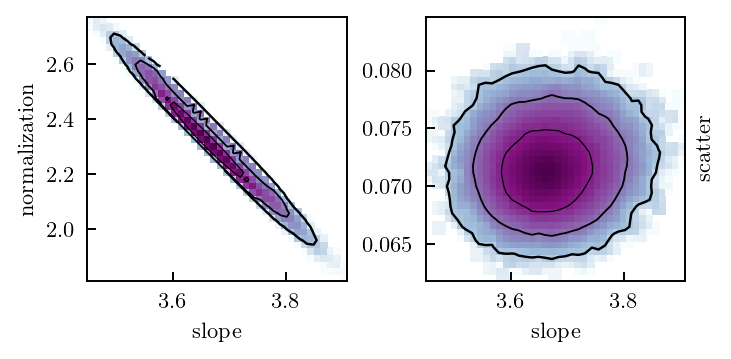

====== Bradford et al. BTFR sample perpendicular likelihood ======
best fit slope:
mean, median = 3.663, 3.662, st.dev=0.0516
68perc interval = 3.613, 3.713
95perc interval = 3.562, 3.767
----------------------------------------------
best fit normalization
mean, median = 2.320, 2.321, st.dev=0.1081
68perc interval = 2.214, 2.425
95perc interval = 2.101, 2.532
----------------------------------------------
best fit scatter:
mean, median = 0.071, 0.071, st.dev=0.0023
68perc interval = 0.069, 0.074
95perc interval = 0.067, 0.076
----------------------------------------------


In [47]:
plot_fit(mi, ci, s, mlim=[np.min(mi), np.max(mi)], clim=[np.min(ci), np.max(ci)], 
         slim=[np.min(s), np.max(s)], p_stats=True)

We can see that we have indeed obtained constraints indistinguishable from that obtained using reverse axes. 

Now let me illustrate what we get when I pivot the fit, by redefining the variables I use in the fit. Namely, instead of fitting

$$\log_{10} M_b = A + \eta\log_{10}V_{\rm max},$$

we fit relation between new variables $\mu = M_b/M_{b,0}$ and $V_{\rm max}/V_{\rm max,0}$, where $M_{b,0}$ and $V_{\rm max,0}$ define the *pivot point* and should be chosen to be in the middle of the ranges of these quantities probed by the data. One choice for $M_{b,0}$ and $V_{\rm max,0}$ is their error-weighted mean, as I chose below. By design, the new relation should have normalization close to zero. The main difference is that for the "pivoted" fit the degeneracy between normalization and slope should also be close to zero.


In [19]:
x = np.log10(w20b); ex = e_x
y = mbbar; ey = embar 

# pivoting
ax = np.sum(x/ex**2.0)/np.sum(1./ex**2.0); ay = np.sum(y/ey**2.0)/np.sum(1./ey**2.0)
x = x - ax; y = y - ay

In [20]:
m, c, s = run_fit(x, ex, y, ey, m0=3.6, c0=0., s0=0.05, ipar_active=np.array([1, 1, 1]))

params [array([ -5.77110737e-01,  -3.92433869e-01,  -3.80761792e-01,
        -4.90712394e-01,  -8.06436868e-01,  -5.14932639e-01,
        -5.95605666e-01,  -2.91904201e-01,  -3.28055057e-01,
        -4.07491174e-01,  -2.99194032e-01,   2.32011808e-02,
        -4.28486261e-02,  -1.07399015e-01,   1.84848873e-01,
         2.35735255e-01,  -2.81875186e-01,  -3.31486439e-01,
         7.64612861e-02,   1.05919795e-03,  -4.25055915e-02,
         1.34339019e-01,  -2.38067958e-01,   2.83823366e-01,
         2.13773662e-01,   2.80415088e-01,  -1.51192065e-01,
        -6.98535275e-02,   2.15726887e-01,  -3.41337503e-01,
        -1.25647197e-01,  -3.77423509e-01,   1.79889073e-01,
        -1.28998637e-01,  -1.31466644e-01,   9.56997757e-02,
         8.37824612e-02,   4.09442029e-03,  -5.09198639e-01,
        -3.43529660e-01,  -4.72619460e-01,  -3.64762022e-01,
         1.71033806e-01,  -2.46990585e-01,  -2.12954307e-01,
        -4.41261552e-01,   1.93089206e-01,  -2.45101818e-01,
         1.24266

/Users/hqchen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in log


nchain = 500; tcorr = 1.52e+01
('R_GR = ', array([ 2.02238178,  1.00416772,  1.0052605 ]))
nchain = 1000; tcorr = 1.54e+01
('R_GR = ', array([ 1.16765069,  1.001997  ,  1.00246445]))
nchain = 1500; tcorr = 1.51e+01
('R_GR = ', array([ 1.0790924 ,  1.00152445,  1.00166791]))
nchain = 2000; tcorr = 6.18e+01
('R_GR = ', array([ 1.04831175,  1.00106417,  1.00125014]))
nchain = 2500; tcorr = 6.02e+01
('R_GR = ', array([ 1.03104709,  1.00096499,  1.00101375]))
nchain = 3000; tcorr = 6.03e+01
('R_GR = ', array([ 1.02254904,  1.00086097,  1.00087189]))
nchain = 3500; tcorr = 5.91e+01
('R_GR = ', array([ 1.01801771,  1.00087779,  1.0007703 ]))
nchain = 4000; tcorr = 5.82e+01
('R_GR = ', array([ 1.01555452,  1.00081428,  1.0007126 ]))
nchain = 4500; tcorr = 5.83e+01
('R_GR = ', array([ 1.01318452,  1.00077503,  1.00062078]))
nchain = 5000; tcorr = 5.76e+01
('R_GR = ', array([ 1.01110056,  1.0007381 ,  1.00054594]))
nchain = 5500; tcorr = 5.78e+01
('R_GR = ', array([ 1.00976723,  1.00072574,  1.0

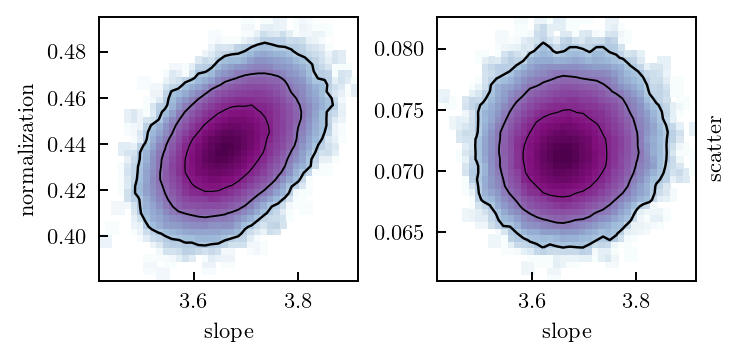

====== Bradford et al. BTFR sample perpendicular likelihood ======
best fit slope:
mean, median = 3.662, 3.662, st.dev=0.0510
68perc interval = 3.613, 3.712
95perc interval = 3.563, 3.765
----------------------------------------------
best fit normalization
mean, median = 0.438, 0.438, st.dev=0.0119
68perc interval = 0.426, 0.449
95perc interval = 0.414, 0.461
----------------------------------------------
best fit scatter:
mean, median = 0.071, 0.071, st.dev=0.0023
68perc interval = 0.069, 0.074
95perc interval = 0.067, 0.076
----------------------------------------------


In [50]:
plot_fit(m, c, s, mlim=[np.min(m), np.max(m)], clim=[np.min(c), np.max(c)], 
         slim=[np.min(s), np.max(s)], p_stats=True)

We can see that indeed the degeneracy of the normalization and slope is mostly eliminated. With proper adjustment of pivot it can be completely removed and joint posterior can be characterized by the variances of slope and normalization without the need to report the full covariance matrix. 

**2) Does the constraint on the scatter and its projecti on to $y$ direction $s=s_\perp\sqrt{1+m^2}$ make sense if you compare them to the residuals of $y-y_{\rm model}$? (5 points)**

Let's compute the rms residual given the fit parameters above: 

$$\sigma_{\rm res} = \left[\frac{1}{N}\sum\limits_{i=0}^{N_{\rm d}} (y_i - mx_i - c)^2\right]^{1/2}$$

and compare it to the total scatter in $y$ direction around best fit line we expect from the fit and from the uncertainties of the data points:

$$s = \left[s_\perp^2(1+m^2) + \sum_i (\sigma_{y,i}^2+m^2\sigma_{x,i}^2)\right]^{1/2}.$$

In [53]:
x = np.log10(w20b); ex = e_x
y = mbbar; ey = embar 

ms = 3.661; cs = 2.33; ss = 0.071

sigma_res = np.sqrt(np.average((y - ms*x - cs)**2))
scatter = np.sqrt(ss**2*(1+ms**2) + np.sum(ey**2 + ms**2*ex**2)/np.size(ey))

print("residual measured scatter wrt best fit linear relation = %.3f"%sigma_res)
print("expected scatter wrt best fit linear relation = %.3f"%scatter)


residual measured scatter wrt best fit linear relation = 0.338
expected scatter wrt best fit linear relation = 0.404


The scatters are comparable, but the actual scatter is somewhat larger. This could arise if the actual relation exhibited by the
data is not fully described by a linear function. 

**4) Repeat 3 for the assymetric likelihood given by eq 3.52 in the updated notes, and posterior in eq. 3.54. How do the slopes in the two fit cases compare for this likelihood? (5 points). **

In [14]:
m, c, s = run_fit(x, ex, y, ey, m0=4., c0=0., s0=0.05, ipar_active=np.array([1, 1, 1]), modelpdf=line_fit_vert_like )

starting sampling with 3 active parameters of the total 3 parameters
nchain = 500; tcorr = 1.38e+01
('R_GR = ', array([ 1.00259674,  1.00094066,  1.02088704]))
nchain = 1000; tcorr = 1.56e+01
('R_GR = ', array([ 1.00124257,  1.00045735,  1.00998947]))
MCMC sampler generated 100000 samples using 100 walkers
with step acceptance ratio of 0.538


C:\Users\h2_sf\Canopy2\User\lib\site-packages\ipykernel\__main__.py:53: RuntimeWarning: invalid value encountered in log


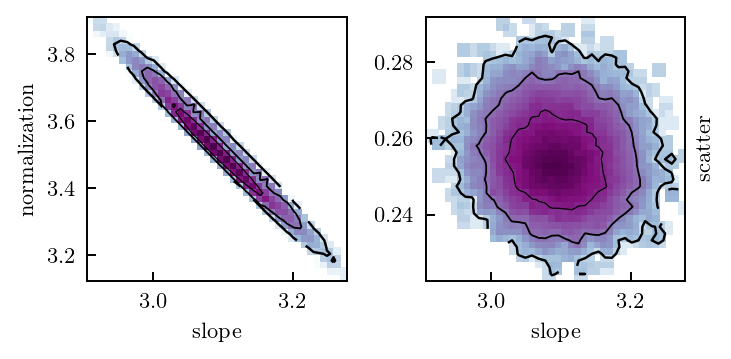

====== Bradford et al. BTFR sample perpendicular likelihood ======
best fit slope:
mean, median = 3.092, 3.092, st.dev=0.0434
68perc interval = 3.050, 3.135
95perc interval = 3.007, 3.178
----------------------------------------------
best fit normalization
mean, median = 3.512, 3.513, st.dev=0.0911
68perc interval = 3.423, 3.601
95perc interval = 3.333, 3.693
----------------------------------------------
best fit scatter:
mean, median = 0.254, 0.253, st.dev=0.0082
68perc interval = 0.246, 0.262
95perc interval = 0.238, 0.271
----------------------------------------------


In [15]:
plot_fit(m, c, s, mlim=[np.min(m), np.max(m)], clim=[np.min(c), np.max(c)], 
         slim=[np.min(s), np.max(s)], p_stats=True)

We can see that for this likelihood the slope is significantly shallower. This illustrates that fit
results do depend on the generative model one assumes for the data and the resulting form of the likelihood. 
The values of slope, normalization, and scatter are close  to the values obtained by Bradford et al. (2016):
$m=3.24\pm 0.05$, $c=3.21\pm 0.10$, $s=0.25\pm 0.01$, although our slope is somewhat shallower. B16 use the method of Kelly (2007), which in addition to the linear fit also models the distribution of data points along $x$ direction with a Gaussian mixture, thereby weighing intervals with different numbers of points differently. This is not done in our model. 

If we now refit with $V_{\rm max}$ as $y$, we get: 

In [50]:
y = np.log10(w20b); ey = e_x
x = mbbar; ex = embar 

In [51]:
m, c, s = run_fit(x, ex, y, ey, m0=1./3.1, c0=0, s0=0.25, ipar_active=np.array([1, 1, 1]), modelpdf=line_fit_vert_like )

starting sampling with 3 active parameters of the total 3 parameters
nchain = 500; tcorr = 1.27e+01
('R_GR = ', array([ 1.02204575,  1.00291824,  1.00718291]))
nchain = 1000; tcorr = 1.28e+01
('R_GR = ', array([ 1.01076325,  1.00177262,  1.00336765]))
nchain = 1500; tcorr = 1.25e+01
('R_GR = ', array([ 1.00744911,  1.00160781,  1.00219789]))
MCMC sampler generated 150000 samples using 100 walkers
with step acceptance ratio of 0.546


C:\Users\h2_sf\Canopy2\User\lib\site-packages\ipykernel\__main__.py:53: RuntimeWarning: invalid value encountered in log


In [52]:
# convert parameter values to the definitions when y = log10(Mb)
mi = 1./np.array(m); 
ci = -mi*c; 

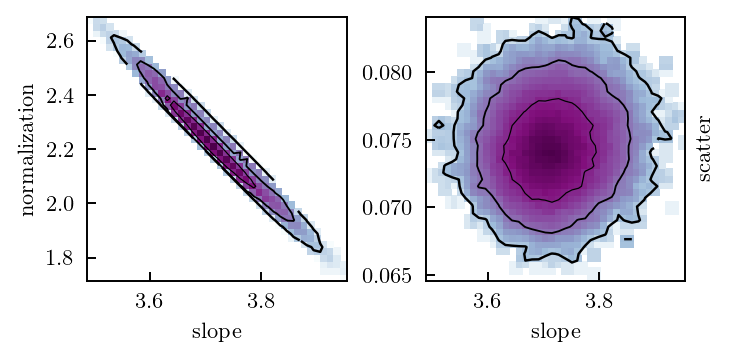

====== Bradford et al. BTFR sample perpendicular likelihood ======
best fit slope:
mean, median = 3.711, 3.710, st.dev=0.0525
68perc interval = 3.659, 3.762
95perc interval = 3.608, 3.817
----------------------------------------------
best fit normalization
mean, median = 2.220, 2.221, st.dev=0.1103
68perc interval = 2.112, 2.327
95perc interval = 1.996, 2.434
----------------------------------------------
best fit scatter:
mean, median = 0.074, 0.074, st.dev=0.0024
68perc interval = 0.072, 0.077
95perc interval = 0.070, 0.079
----------------------------------------------


In [53]:
plot_fit(mi, ci, s, mlim=[np.min(mi), np.max(mi)], clim=[np.min(ci), np.max(ci)], 
         slim=[np.min(s), np.max(s)], p_stats=True)

We can see that in this case, the fit results depend on which variable we adopt as $y$ and $x$. This, of course, is expected for this likelihood which is explicitly not symmetric wrt $x$ and $y$. However, this should be unsettling, as in this case there is no particular reason to prefer one of the quantities to be $y$. 